In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_folder=os.path.normcase(r'C:\Users\dell\Downloads\Titanic-maching-learning-from-disaster')
train_data=pd.read_csv(os.path.join(path_folder,'train.csv'),sep=',')
test_data_origin=pd.read_csv(os.path.join(path_folder,'test.csv'),sep=',')

In [3]:
def deal_ticket_fare(df):
    '''
    计算每张票有几人共享，以及每人花费的船票钱
    
    paramters:
        df--dataframe，待处理的数据表
        
    return:
        df_count--处理后，添加新列的数据表
    '''
    num_of_tickets=df[['Ticket']].groupby(df['Ticket']).count()
    num_of_tickets.columns=['num_of_tickets']
    df_count=df.merge(num_of_tickets,left_on='Ticket',right_index=True,how='left')
    df_count['fare_per_ticket']=df_count['Fare']/df_count['num_of_tickets']
    return df_count

In [4]:
# 构造 数据预处理 流水线
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator,TransformerMixin

class DataFrameSelector(BaseEstimator,TransformerMixin):
    def __init__(self,attrs_name_list):
        self.attrs_name_list=attrs_name_list
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X[self.attrs_name_list].values

def data_preparation(cat_attributes,interval_num_attributes,ratio_num_attributes):
    '''
    构造处理DataFrame 的 类
    
    Arguments:
        cat_attributes ---         标称数据列集合
        interval_num_attributes--- 标度数值列集合/不需进行标准化的列集合
        ratio_num_attributes   --- 比例数值列集合/需进行 标准化 列集合
       
    Return 
        full_pipeline---类class
    '''
    cat_attrs=cat_attributes    
    interval_num_attrs=interval_num_attributes
    ratio_num_attrs=ratio_num_attributes
    transformer_list=[]
    
    if cat_attrs:
        cat_pipeline=Pipeline([('cat_dfs',DataFrameSelector(cat_attrs)),('impute',SimpleImputer(strategy='most_frequent')),\
                               ('onehotencoder',OneHotEncoder())])
        transformer_list.append(('cat_pipeline',cat_pipeline))
        
    if interval_num_attrs:
        interval_num_pipeline=Pipeline([('dfs',DataFrameSelector(interval_num_attrs)),('impute',SimpleImputer(strategy='median')) ])
        transformer_list.append(('interval_num_pipeline',interval_num_pipeline))
        
    if ratio_num_attrs:    
        ratio_num_pipeline=Pipeline([('dfs',DataFrameSelector(ratio_num_attrs)),('impute',SimpleImputer(strategy='median')),\
                                     ('std_scaler',StandardScaler())])
        transformer_list.append(('ratio_num_pipeline',ratio_num_pipeline))
    full_pipeline=FeatureUnion(transformer_list=transformer_list)
    return full_pipeline

In [5]:
# scale 数值数据
train_data_count=deal_ticket_fare(train_data)
from sklearn.model_selection import train_test_split
#train_data_index,dev_data_index=train_test_split(train_data_count.index.tolist(),train_size=0.7,test_size=0.3,random_state=42)
#train_df_data=train_data_count.iloc[train_data_index,:]
#dev_df_data=train_data_count.iloc[dev_data_index,:]
train_df_data,dev_df_data=train_test_split(train_data_count,train_size=0.7,test_size=0.3,random_state=42)
train_data_index=train_df_data.index.tolist()
dev_data_index=dev_df_data.index.tolist()
cat_attrs=['Sex','Embarked']    
interval_num_attrs=['Pclass','SibSp','Parch','num_of_tickets']
ratio_num_attrs=['Age','Fare','fare_per_ticket']
full_pipeline_std=data_preparation(cat_attrs,interval_num_attrs,ratio_num_attrs)
#train_data_X=full_pipeline_std.fit_transform(train_df_data).toarray()
#train_data_y=train_df_data['Survived'].values.ravel()
train_data_X=full_pipeline_std.fit_transform(train_data_count).toarray()
train_data_y=train_data_count['Survived'].values.ravel()
train_data_X[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        3.        ,  1.        ,  0.        ,  1.        , -0.56573646,
       -0.50244517, -0.49697568])

In [6]:
set(train_data_index)&set(dev_data_index)

set()

In [7]:
dev_data_X=full_pipeline_std.transform(dev_df_data).toarray()
dev_data_y=dev_df_data['Survived'].values.ravel()
dev_data_X[0]

array([ 0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        3.        ,  1.        ,  1.        ,  2.        , -0.0772525 ,
       -0.32547755, -0.49449441])

In [88]:
# not scale the data
train_data_count=deal_ticket_fare(train_data)
cat_attrs=['Sex','Embarked']    
interval_num_attrs=['Pclass','SibSp','Parch','num_of_tickets','Age','Fare','fare_per_ticket']
ratio_num_attrs=[]
full_pipeline=data_preparation(cat_attrs,interval_num_attrs,ratio_num_attrs)
train_data_X=full_pipeline.fit_transform(train_data_count).toarray()
train_data_y=train_data_count['Survived'].values.ravel()
train_data_X[0]

array([  0.  ,   1.  ,   0.  ,   0.  ,   1.  ,   3.  ,   1.  ,   0.  ,
         1.  ,  22.  ,   7.25,   7.25])

In [8]:
def compute_acc(y,y_pred):
    y_pred_class=np.where(y_pred>0.5,1,0)
    pred_accuracy=(y==y_pred_class).sum()/len(y)    
    return pred_accuracy

In [10]:
model_score_dict={}

In [14]:
# 线性模型-逻辑斯蒂回归
from sklearn.linear_model import LogisticRegression
lin_clf=LogisticRegression(penalty='l1',solver='liblinear')

In [16]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(lin_clf,train_data_X,train_data_y,cv=10,n_jobs=-1)
print (scores,np.mean(scores))

[0.75       0.76190476 0.88709677 0.85483871 0.80645161 0.72580645
 0.72580645 0.77419355 0.69354839 0.91935484] 0.789900153609831


In [15]:
lin_clf.fit(train_data_X,train_data_y)
lin_dev_y=lin_clf.predict(dev_data_X)
lin_acc=compute_acc(dev_data_y,lin_dev_y)
#lin_y_pred=np.where(lin_dev_y>0.5,1,0)
#lin_acc=(lin_y_pred==dev_data_y).sum()/len(dev_data_y)
print ('LogisticRegression accuracy:',lin_acc)

LogisticRegression accuracy: 0.8022388059701493


In [17]:
model_score_dict['LogitsticRegression']=scores.mean()

In [14]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    from sklearn.model_selection import learning_curve
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)#train_scores size (n_ticks,n_cv_folds)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 's-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

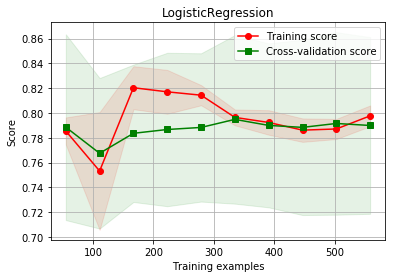

In [19]:
plot_learning_curve(lin_clf,'LogisticRegression',train_data_X,train_data_y,cv=10)
plt.show()

In [20]:
# 随机梯度下降
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
sgd_clf=SGDClassifier(penalty='l1',max_iter=1000,tol=1e-4)
#sgd_clf.fit(train_data_X,train_data_y)
scores=cross_val_score(sgd_clf,train_data_X,train_data_y,cv=10)

In [21]:
#sgd_clf.predict(dev_data_X)

In [22]:
model_score_dict['SGDClassifier']=scores.mean()

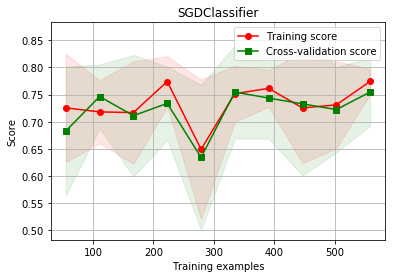

In [23]:
plot_learning_curve(sgd_clf,'SGDClassifier',train_data_X,train_data_y,cv=10)
plt.show()

In [24]:
# 支持向量机 SVM  ----scale 后的数据，模型的性能更好
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm_clf=SVC(C=1.0,tol=1e-4,max_iter=5000,gamma='auto')
scores=cross_val_score(svm_clf,train_data_X,train_data_y,cv=10)
print (scores.mean())

0.8236447132616487


In [25]:
svm_clf.fit(train_data_X,train_data_y)
svm_y_pred=np.where(svm_clf.predict(dev_data_X)>0.5,1,0)
svm_acc=(svm_y_pred==dev_data_y).sum()/len(dev_data_y)
print (svm_acc)

0.8208955223880597


In [26]:
model_score_dict['SVM']=scores.mean()

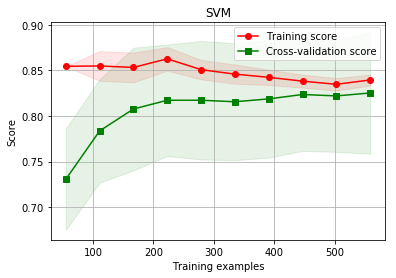

In [27]:
plot_learning_curve(svm_clf,'SVM',train_data_X,train_data_y,cv=10)
plt.show()

In [28]:
# Knn 最近邻
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier(n_neighbors=3,algorithm='auto',leaf_size=30,p=2,n_jobs=-1)
#scores=cross_val_score(nbrs,train_data_X,train_data_y,cv=10)
#knn_clf.fit(train_data_X,train_data_y)

In [29]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(knn_clf,train_data_X,train_data_y,cv=10)
scores

array([0.75      , 0.76190476, 0.77419355, 0.85483871, 0.77419355,
       0.77419355, 0.80645161, 0.79032258, 0.74193548, 0.83870968])

In [30]:
model_score_dict['KNeighborsClassifier']=scores.mean()

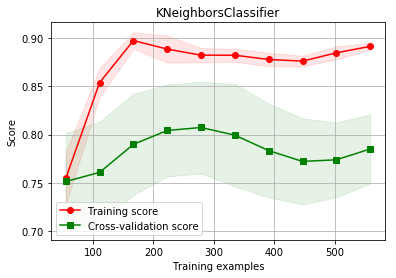

In [31]:
plot_learning_curve(knn_clf,'KNeighborsClassifier',train_data_X,train_data_y,cv=10)
plt.show()

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
nb_clf=GaussianNB()
scores=cross_val_score(nb_clf,train_data_X,train_data_y,cv=10,n_jobs=-1)

In [33]:
model_score_dict['GaussianNB']=scores.mean()

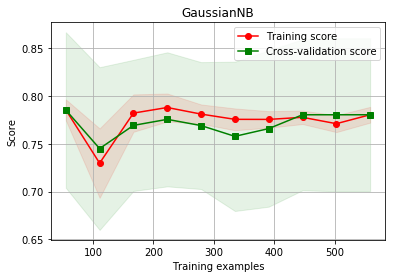

In [34]:
plot_learning_curve(nb_clf,'GaussianNB',train_data_X,train_data_y,cv=10)
plt.show()

In [35]:
# 决策树
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
dt_clf=DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=None,min_samples_split=12,min_samples_leaf=7)
scores=cross_val_score(dt_clf,train_data_X,train_data_y,cv=10)
scores

array([0.734375  , 0.80952381, 0.91935484, 0.87096774, 0.77419355,
       0.79032258, 0.79032258, 0.79032258, 0.75806452, 0.87096774])

In [36]:
model_score_dict['DecisionTreeClassifier']=scores.mean()

0.8108414938556067


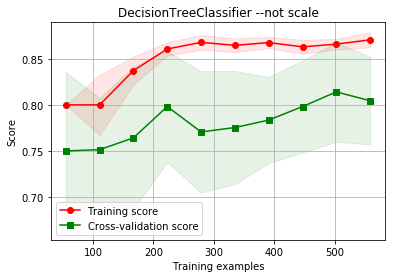

In [37]:
print (scores.mean())
plot_learning_curve(dt_clf,'DecisionTreeClassifier --not scale',train_data_X,train_data_y,cv=10)
plt.show()

0.8108414938556067


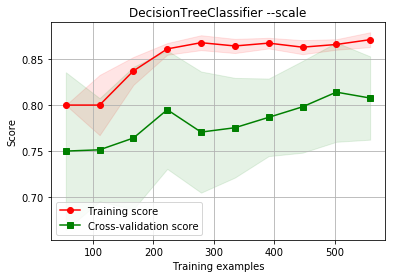

In [38]:
print (scores.mean())
plot_learning_curve(dt_clf,'DecisionTreeClassifier --scale',train_data_X,train_data_y,cv=10)
plt.show()

In [39]:
# Ensemble methods
#adaboost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
adaboost_clf=AdaBoostClassifier(n_estimators=50,learning_rate=1.0)
scores=cross_val_score(adaboost_clf,train_data_X,train_data_y,cv=10)
model_score_dict['AdaBoostClassifier']=scores.mean()

0.8076164874551971 



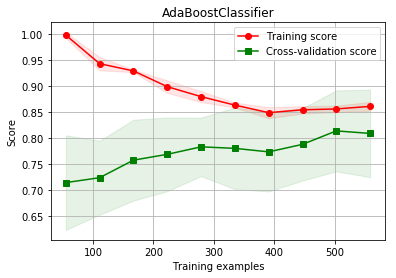

In [40]:
print (scores.mean(),'\n')
plot_learning_curve(adaboost_clf,'AdaBoostClassifier',train_data_X,train_data_y,cv=10)
plt.show()

In [16]:
# random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
rf_clf=RandomForestClassifier(n_estimators=100)#,min_samples_split=12,min_samples_leaf=6
scores=cross_val_score(rf_clf,train_data_X,train_data_y,cv=10)
model_score_dict['RandomForestClassifier']=scores.mean()
print (scores.mean())

0.801164074500768


In [17]:
rf_clf.fit(train_data_X,train_data_y)
rf_y_pred=np.where(rf_clf.predict(dev_data_X)>0.5,1,0)
rf_acc=(rf_y_pred==dev_data_y).sum()/len(dev_data_y)
print (rf_acc)

0.7761194029850746


0.801164074500768 



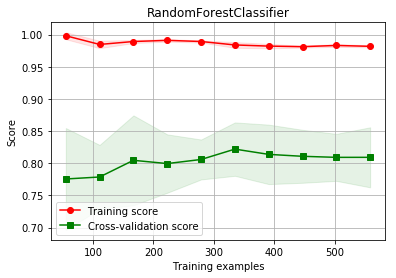

In [18]:
print (scores.mean(),'\n')
plot_learning_curve(rf_clf,'RandomForestClassifier',train_data_X,train_data_y,cv=10)
plt.show()

In [44]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data_X,train_data_y,test_size=0.3)

In [8]:
test_data=deal_ticket_fare(test_data_origin)
test_data_X=full_pipeline_std.transform(test_data)

In [22]:
import lightgbm as lgb
train_data=lgb.Dataset(train_data_X,label=train_data_y)
#validation_data=train_data.create_valid('validation.svm')
#test_data = train_data.create_valid('test.svm')
#test_data=lgb.Dataset(dev_data_X)
param={'num_leaves':21,'num_trees':100,'objective':'binary'}
param['metric']=['accuracy']
num_round=10
bst=lgb.train(param,train_data,num_round,valid_sets=train_data)
bst.save_model('model.txt')
test_y_pred=bst.predict(test_data_X)

C:\Users\dell\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [19]:
y_pred_c=np.where(dev_y_pred>0.5,1,0)
accuracy=(y_pred_c==dev_data_y).sum()/len(y_pred_c)

NameError: name 'dev_y_pred' is not defined

In [20]:
test_data_origin['Survived']=np.where(test_y_pred>0.5,1,0)

In [21]:
test_data_origin[['PassengerId','Survived']].to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)

In [47]:
((y_pred_c==dev_data_y)&(y_pred_c==0)).sum()

134

In [48]:
train_data_X.shape

(623, 12)

In [64]:
#train_data_X[(y_pred_c!=train_data_y).tolist()]

In [49]:
accuracy

0.7947761194029851

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(dev_data_y,y_pred_c)

array([[134,  23],
       [ 32,  79]], dtype=int64)

In [51]:
model_score_dict['GBDT']=accuracy

In [52]:
test_data_origin_count=deal_ticket_fare(test_data_origin)
cat_attrs=['Sex','Embarked']    
interval_num_attrs=['Pclass','SibSp','Parch','num_of_tickets']
ratio_num_attrs=['Age','Fare','fare_per_ticket']
full_pipeline_std=data_preparation(cat_attrs,interval_num_attrs,ratio_num_attrs)
test_data_origin_X=full_pipeline_std.fit_transform(test_data_origin_count).toarray()
#test_data_origin_y=test_data_origin_count['Survived'].values.ravel()
test_data_origin_X[0]

array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        3.        ,  0.        ,  0.        ,  1.        ,  0.38623105,
       -0.49741333, -0.44294796])

In [53]:
y_pred_svm=svm_clf.predict(test_data_origin_X)
y_pred_rf=rf_clf.predict(test_data_origin_X)
y_pred_comb=0.6*y_pred_svm+0.4*y_pred_rf
test_y_pred=np.where(y_pred_comb>0.5,1,0)

In [55]:
test_y_pred.ravel().shape

(418,)

In [56]:
test_pred_data=test_data_origin.loc[:,['PassengerId']]
test_pred_data['Survived']=test_y_pred
test_pred_data.to_csv('c:/users/dell/desktop/gender_submission.csv',index=False)

In [57]:
test_pred_data.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [58]:
model_score_dict

{'AdaBoostClassifier': 0.8076164874551971,
 'DecisionTreeClassifier': 0.8108414938556067,
 'GBDT': 0.7947761194029851,
 'GaussianNB': 0.7802987391193037,
 'KNeighborsClassifier': 0.7866743471582182,
 'LogitsticRegression': 0.789900153609831,
 'RandomForestClassifier': 0.8141185035842293,
 'SGDClassifier': 0.7433795762928829,
 'SVM': 0.8236447132616487}

In [59]:
import operator
sortedmodel=sorted(model_score_dict.items(),key=operator.itemgetter(1),reverse=True)
sortedmodel[:5]

[('SVM', 0.8236447132616487),
 ('RandomForestClassifier', 0.8141185035842293),
 ('DecisionTreeClassifier', 0.8108414938556067),
 ('AdaBoostClassifier', 0.8076164874551971),
 ('GBDT', 0.7947761194029851)]

In [48]:
# RF fine_tune
from sklearn.model_selection import GridSearchCV
param_grid={'criterion':['gini','entropy'],'min_samples_leaf':[1,2,3,4],'min_samples_split':[7,8,9,10]}
gs=GridSearchCV(estimator=rf_clf,param_grid=param_grid,scoring='accuracy',cv=3,n_jobs=2)
gs.fit(train_data_X,train_data_y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'min_samples_split': [7, 8, 9, 10], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [49]:
gs.best_score_

0.8294051627384961

In [50]:
gs.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 9}

In [51]:
plot_learning_curve()

TypeError: plot_learning_curve() missing 4 required positional arguments: 'estimator', 'title', 'X', and 'y'